In [1]:
%load_ext autoreload
%autoreload 2
# import basic package
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# import the necessary package
from baseline.PyOD import PYOD
from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior, MultivariateNormalPrior
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
import numpy as np
from tqdm import trange
datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

In [2]:
# dataset and model list / dict
dataset_list = [
    "01_ALOI",
    "02_annthyroid",
    "03_backdoor",
    "04_breastw",
    "05_campaign",
    "06_cardio",
    "07_Cardiotocography",
    "08_celeba",
    "09_census",
    "99_linear",
]

In [3]:
dataset = dataset_list[5]
datagenerator.dataset = dataset
data = datagenerator.generator(la=1.0, realistic_synthetic_mode=None, noise_type=None)

current noise type: None
{'Samples': 1831, 'Features': 21, 'Anomalies': 176, 'Anomalies Ratio(%)': 9.61}


In [4]:
Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

In [5]:
idx_a = np.where(lb_train==1)[0]
idx_n = np.where(lb_train==0)[0]

In [6]:
Y_train = Y_train[idx_n, :]

In [13]:
model_dict = {}
noise_trace_dict = {}
N = len(Y_train)
data_dim = Y_train.shape[1]
latent_dim = 2
n_inducing = 25
batch_size = 100
n_epochs = 1000
nn_layers = (10,5)
lr = 0.01

# Define prior for X
X_prior_mean = torch.zeros(N, latent_dim)  # shape: N x Q
prior_x = MultivariateNormalPrior(X_prior_mean, torch.eye(X_prior_mean.shape[1]))

# Initialise model, likelihood, elbo and optimizer and latent variable encoder

encoder = NNEncoder(N, latent_dim, prior_x, data_dim, layers=nn_layers)
model = AEB_GPLVM(N, data_dim, latent_dim, n_inducing, encoder, nn_layers=nn_layers)
likelihood = GaussianLikelihood()
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr
)
elbo = VariationalELBO(likelihood, model, num_data=len(Y_train))

# Model params
print(f'Training model params for model {"GPLVM"}')
model.get_trainable_param_names()

# Training loop - optimises the objective wrt kernel hypers, variational params and inducing inputs
# using the optimizer provided.

loss_list = []
noise_trace = []

iterator = trange(n_epochs, leave=True)
for i in iterator:
    batch_index = model._get_batch_idx(batch_size)
    optimizer.zero_grad()
    sample_batch = model.sample_latent_variable(Y_train)[batch_index] # batch de variaveis latentes
    output_batch = model(sample_batch) # isso aqui decoda as variaveis latentes 
    loss = -elbo(output_batch, Y_train[batch_index].T).sum() # aqui eu pego a diferença
    loss_list.append(loss.item())
    noise_trace.append(np.round(likelihood.noise_covar.noise.item(), 3))
    if i % 50 == 0:
        iterator.set_description(
            "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: " + str(i)
        )
    loss.backward()
    optimizer.step()
model.store(loss_list, likelihood)

# Save models & training info

#print(model.covar_module.base_kernel.lengthscale)
noise_trace_dict["GPLVM"] = noise_trace
X_train_mean = model.get_X_mean(Y_train)
#X_train_scales = model.get_X_scales(Y_train)


Training model params for model GPLVM
+-----------------------------------------------------------------------+------------+
|                                Modules                                | Parameters |
+-----------------------------------------------------------------------+------------+
|                  variational_strategy.inducing_points                 |     50     |
|    variational_strategy._variational_distribution.variational_mean    |    525     |
| variational_strategy._variational_distribution.chol_variational_covar |   13125    |
|                          X.mu_layers.0.weight                         |    210     |
|                           X.mu_layers.0.bias                          |     10     |
|                          X.mu_layers.1.weight                         |     50     |
|                           X.mu_layers.1.bias                          |     5      |
|                          X.mu_layers.2.weight                         |     10     |
|    

Loss: -12.38, iter no: 950: 100%|██████████| 1000/1000 [00:09<00:00, 100.07it/s]


In [ ]:

with torch.no_grad():
    model.eval()
    likelihood.eval()

X_test_mean, X_test_covar = model.predict_latent(Y_test)
Y_test_mean, Y_test_covar = model.reconstruct_y(Y_test) 

## amostra -> nn_ecoder --> model.decoder --> amostra_reconstruida
## ou seja, vira uma variavel latente, depois passa pelo modelo
## para se tornar de novo algo no espaço dos dados

In [8]:
def scatter_Y_test(Y_test, lb_test):
    idx_n = np.where(lb_test == 0) 
    idx_a = np.where(lb_test == 1)
    plt.scatter(Y_test_mean[0,idx_a],Y_test_mean[1,idx_a])
    plt.scatter(Y_test_mean[0,idx_n],Y_test_mean[1,idx_n])

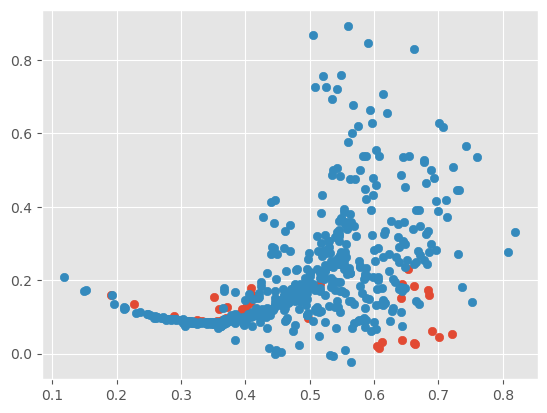

In [10]:
scatter_Y_test(Y_test, lb_test)

In [ ]:
# seed for reproducible results
seed = 42

# clf = clf(seed=seed, model_name=name)
# clf = clf.fit(X_train=data["X_train"], y_train=data["y_train"])
# score = clf.predict_score(data["X_test"])
# result = utils.metric(y_true=data["y_test"], y_score=score)
# df_AUCROC.loc[dataset, name] = result["aucroc"]
# df_AUCPR.loc[dataset, name] = result["aucpr"]